In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
os.listdir("/content/drive/MyDrive/Projeto_Pneumonia/chest_xray")

['val', 'train', 'chest_xray', '__MACOSX', 'test']

In [ ]:
#Verificar quantas imagens de pneumonia tem na pasta train
len(os.listdir("/content/drive/MyDrive/Projeto_Pneumonia/chest_xray/train/PNEUMONIA"))

3877

In [ ]:
#Caminho de cada diretório
train_dir = "/content/drive/MyDrive/Projeto_Pneumonia/chest_xray/train"
test_dir = "/content/drive/MyDrive/Projeto_Pneumonia/chest_xray/test"
val_dir = "/content/drive/MyDrive/Projeto_Pneumonia/chest_xray/val"

#Imprimindo a quantidade de imagens em cada diretório com imagens de pacientes normais e com pneumonia
print("Train set:\n========================================")
num_pneumonia = len(os.listdir(os.path.join(train_dir, 'PNEUMONIA')))
num_normal = len(os.listdir(os.path.join(train_dir, 'NORMAL')))
print(f"PNEUMONIA={num_pneumonia}")
print(f"NORMAL={num_normal}")

print("Test set:\n========================================")
print(f"PNEUMONIA={len(os.listdir(os.path.join(test_dir, 'PNEUMONIA')))}")
print(f"NORMAL={len(os.listdir(os.path.join(test_dir, 'NORMAL')))}")

print("Validation set:\n========================================")
print(f"PNEUMONIA={len(os.listdir(os.path.join(val_dir, 'PNEUMONIA')))}")
print(f"NORMAL={len(os.listdir(os.path.join(val_dir, 'NORMAL')))}")



Train set:
PNEUMONIA=3877
NORMAL=1341
Test set:
PNEUMONIA=390
NORMAL=234
Validation set:
PNEUMONIA=8
NORMAL=8


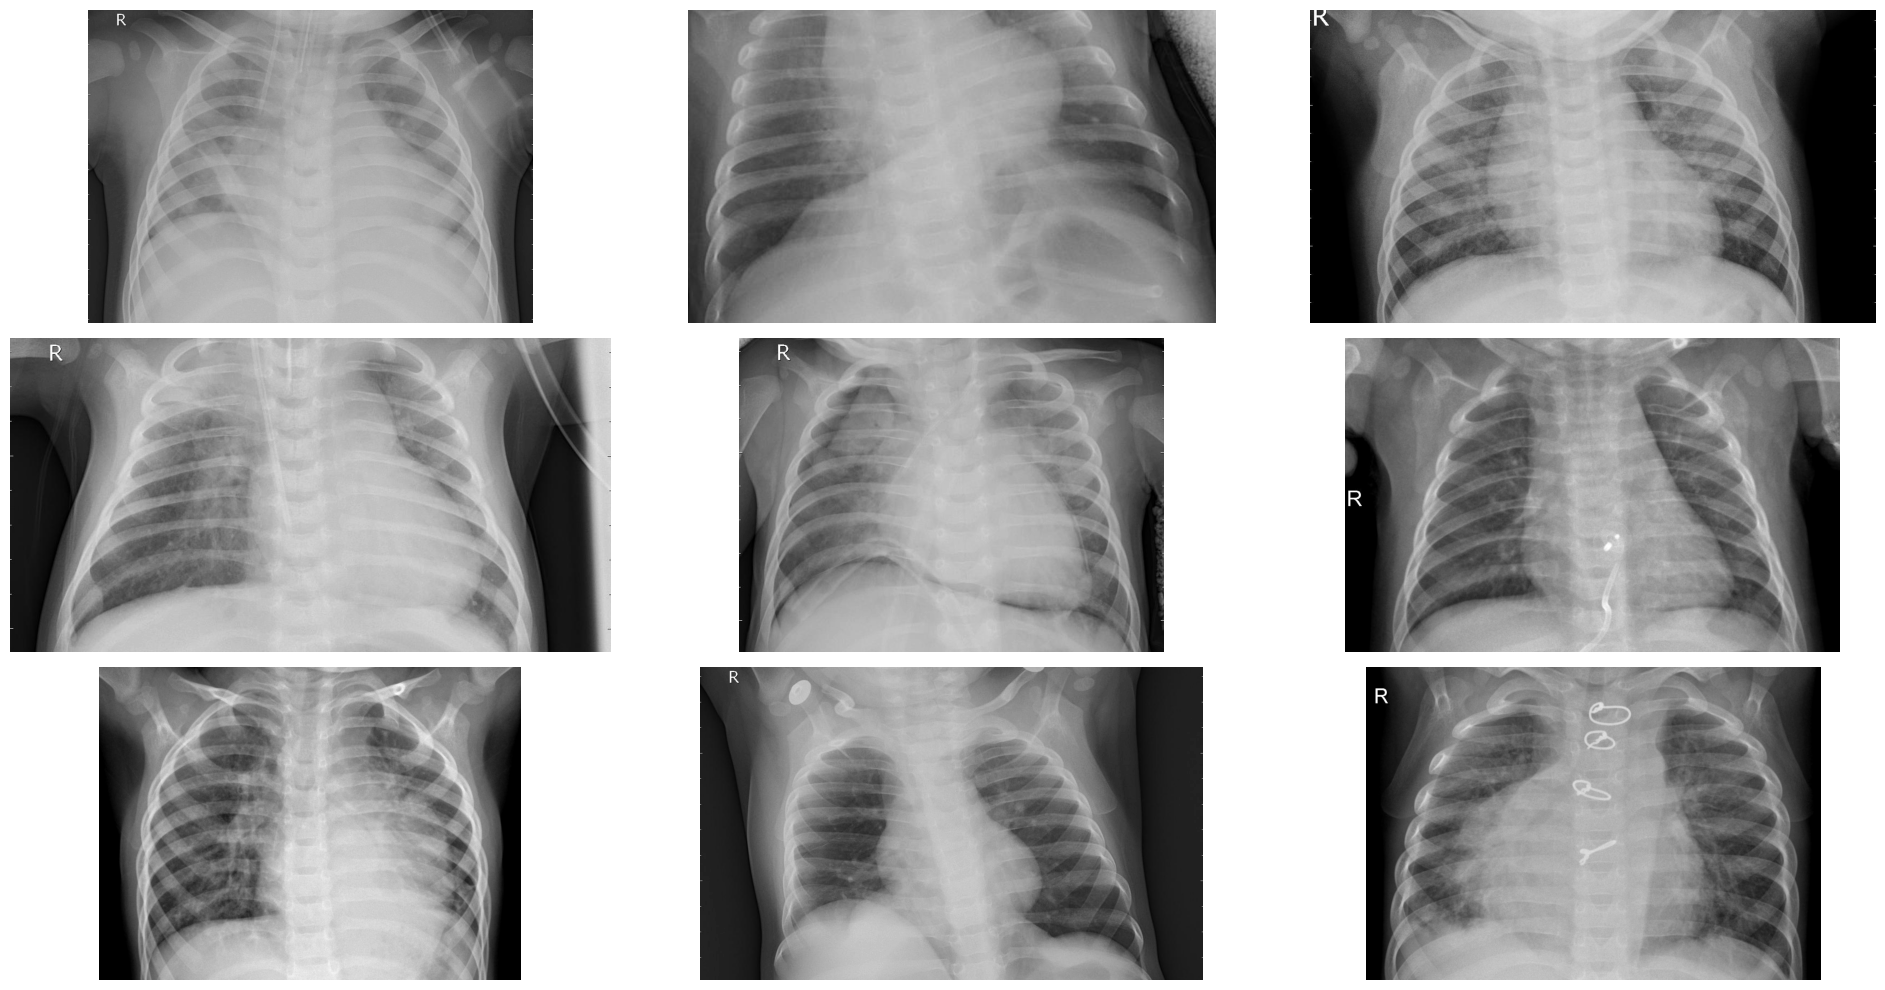

In [ ]:
#Imprimindo um recorte das imagens do diretório train
pneumonia = os.listdir("/content/drive/MyDrive/Projeto_Pneumonia/chest_xray/train/PNEUMONIA")
pneumonia_dir = "/content/drive/MyDrive/Projeto_Pneumonia/chest_xray/train/PNEUMONIA"

plt.figure(figsize=(20, 10))

for i in range(9):
    plt.subplot(3, 3, i + 1)
    img = plt.imread(os.path.join(pneumonia_dir, pneumonia[i]))
    plt.imshow(img, cmap='gray')
    plt.axis('off')

plt.tight_layout()

The dimensions of the image are 1175 pixels width and 1728 pixels height, one single color channel.
The maximum pixel value is 255.0000 and the minimum is 0.0000
The mean value of the pixels is 108.3405 and the standard deviation is 67.7860


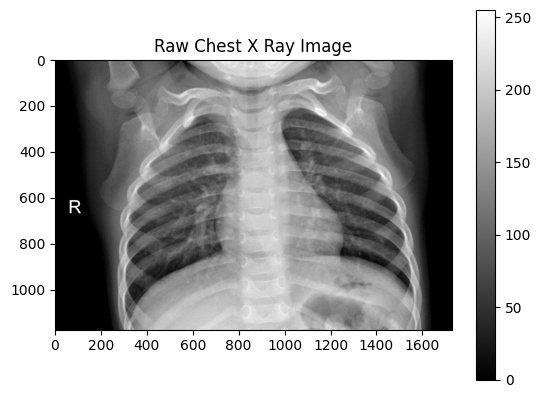

In [ ]:
#Dimensões das imagens
normal_img = os.listdir("/content/drive/MyDrive/Projeto_Pneumonia/chest_xray/train/NORMAL")[0]
normal_dir = "/content/drive/MyDrive/Projeto_Pneumonia/chest_xray/train/NORMAL"
sample_img = plt.imread(os.path.join(normal_dir, normal_img))
plt.imshow(sample_img, cmap='gray')
plt.colorbar()
plt.title('Raw Chest X Ray Image')

print(f"The dimensions of the image are {sample_img.shape[0]} pixels width and {sample_img.shape[1]} pixels height, one single color channel.")
print(f"The maximum pixel value is {sample_img.max():.4f} and the minimum is {sample_img.min():.4f}")
print(f"The mean value of the pixels is {sample_img.mean():.4f} and the standard deviation is {sample_img.std():.4f}")

<ipython-input-14-4a52a8e6963a>:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(sample_img.ravel(),


Text(0, 0.5, '# Pixels in Image')

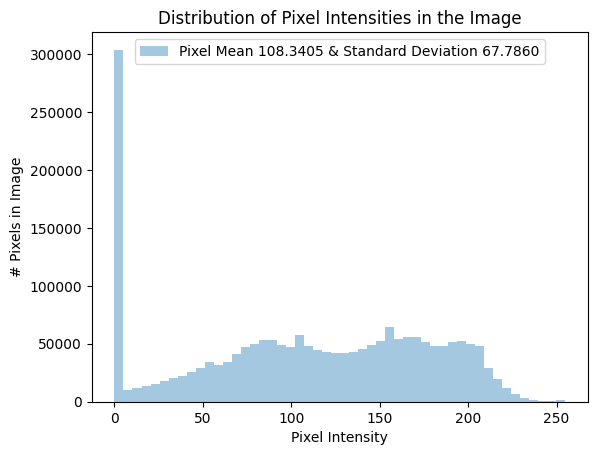

In [ ]:
#Distribuição dos valores dos pixels
sns.distplot(sample_img.ravel(),
            label=f"Pixel Mean {np.mean(sample_img):.4f} & Standard Deviation {np.std(sample_img):.4f}", kde=False)
plt.legend(loc='upper center')
plt.title('Distribution of Pixel Intensities in the Image')
plt.xlabel('Pixel Intensity')
plt.ylabel('# Pixels in Image')

In [ ]:
#Temos que modificar as imagens para serem mais adequadas ao treinamento de uma rede neural convolucional.
#Usaremos a função Keras ImageDataGenerator para realizar o pré-processamento.

from keras.preprocessing.image import ImageDataGenerator

image_generator = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    samplewise_center=True,
    samplewise_std_normalization=True
)

In [ ]:
'''Construindo um gerador novo para validação e teste
Não se pode usar o mesmo gerador dos dados de treinamento ele normaliza cada imagem por lote,
o que significa que usa estatísticas de lote.
Não devemos fazer isso com os dados de teste e validação, pois em um cenário da vida real
não processamos as imagens recebidas em lote por vez  (processamos uma imagem por vez).
Conhecer a média por lote de dados de teste daria efetivamente uma vantagem ao nosso modelo
(o modelo não deve ter nenhuma informação sobre os dados de teste).
O que precisamos fazer é normalizar os dados de teste recebidos usando as estatísticas calculadas
a partir do conjunto de treinamento.'''
train = image_generator.flow_from_directory(train_dir,
                                            batch_size=8,
                                            shuffle=True,
                                            class_mode='binary',
                                            target_size=(180, 180))

validation = image_generator.flow_from_directory(val_dir,
                                                batch_size=1,
                                                shuffle=False,
                                                class_mode='binary',
                                                target_size=(180, 180))

test = image_generator.flow_from_directory(test_dir,
                                            batch_size=1,
                                            shuffle=False,
                                            class_mode='binary',
                                            target_size=(180, 180))

Found 5218 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


The dimensions of the image are 180 pixels width and 180 pixels height, one single color channel.
The maximum pixel value is 3.4237 and the minimum is -3.9084
The mean value of the pixels is 0.0000 and the standard deviation is 1.0000


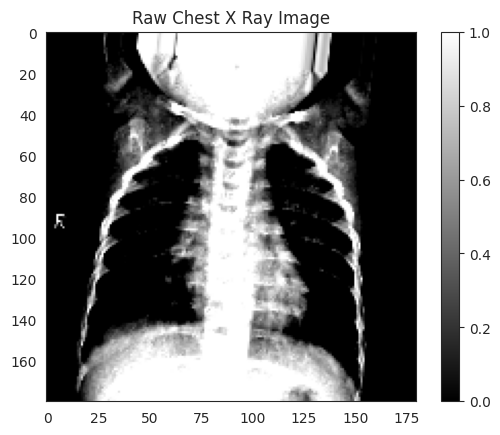

In [ ]:
sns.set_style('white')
generated_image, label = train.__getitem__(0)
plt.imshow(generated_image[0], cmap='gray')
plt.colorbar()
plt.title('Raw Chest X Ray Image')

print(f"The dimensions of the image are {generated_image.shape[1]} pixels width and {generated_image.shape[2]} pixels height, one single color channel.")
print(f"The maximum pixel value is {generated_image.max():.4f} and the minimum is {generated_image.min():.4f}")
print(f"The mean value of the pixels is {generated_image.mean():.4f} and the standard deviation is {generated_image.std():.4f}")

The dimensions of the image are 180 pixels width and 180 pixels height, one single color channel.
The maximum pixel value is 2.7535 and the minimum is -3.7534
The mean value of the pixels is -0.0000 and the standard deviation is 1.0000


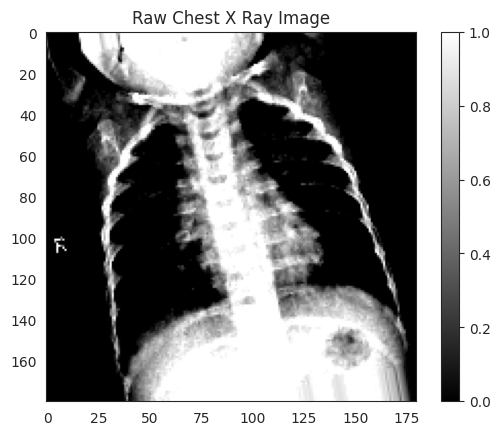

In [ ]:
sns.set_style('white')
generated_image, label = train.__getitem__(0)
plt.imshow(generated_image[0], cmap='gray')
plt.colorbar()
plt.title('Raw Chest X Ray Image')

print(f"The dimensions of the image are {generated_image.shape[1]} pixels width and {generated_image.shape[2]} pixels height, one single color channel.")
print(f"The maximum pixel value is {generated_image.max():.4f} and the minimum is {generated_image.min():.4f}")
print(f"The mean value of the pixels is {generated_image.mean():.4f} and the standard deviation is {generated_image.std():.4f}")

In [ ]:
# Class weights

weight_for_0 = num_pneumonia / (num_normal + num_pneumonia)
weight_for_1 = num_normal / (num_normal + num_pneumonia)

class_weight = {0: weight_for_0, 1: weight_for_1}

print(f"Weight for class 0: {weight_for_0:.2f}")
print(f"Weight for class 1: {weight_for_1:.2f}")

Weight for class 0: 0.74
Weight for class 1: 0.26


In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D, Dropout, Flatten, BatchNormalization


model = Sequential()

model.add(Conv2D(filters=32, kernel_size=(3, 3), input_shape=(180, 180, 3), activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(filters=32, kernel_size=(3, 3), input_shape=(180, 180, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 178, 178, 32)      896       
                                                                 
 batch_normalization (BatchN  (None, 178, 178, 32)     128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 176, 176, 32)      9248      
                                                                 
 batch_normalization_1 (Batc  (None, 176, 176, 32)     128       
 hNormalization)                                                 
                                                                 
 max_pooling2d (MaxPooling2D  (None, 88, 88, 32)       0         
 )                                                               
                                                        

In [ ]:
r = model.fit(
    train,
    epochs=10,
    validation_data=validation,
    class_weight=class_weight,
    steps_per_epoch=100,
    validation_steps=25,
)

Epoch 1/10
100/100 [==============================] - ETA: 0s - loss: 0.8345 - accuracy: 0.8087

100/100 [==============================] - 201s 2s/step - loss: 0.8345 - accuracy: 0.8087 - val_loss: 4.3302 - val_accuracy: 0.5625
Epoch 2/10
100/100 [==============================] - 153s 2s/step - loss: 0.2248 - accuracy: 0.8338
Epoch 3/10
100/100 [==============================] - 134s 1s/step - loss: 0.1594 - accuracy: 0.8700
Epoch 4/10
100/100 [==============================] - 135s 1s/step - loss: 0.1145 - accuracy: 0.8913
Epoch 5/10
100/100 [==============================] - 138s 1s/step - loss: 0.1410 - accuracy: 0.8788
Epoch 6/10
100/100 [==============================] - 133s 1s/step - loss: 0.0674 - accuracy: 0.9325
Epoch 7/10
100/100 [==============================] - 133s 1s/step - loss: 0.1409 - accuracy: 0.8888
Epoch 8/10
100/100 [==============================] - 131s 1s/step - loss: 0.1397 - accuracy: 0.8913
Epoch 9/10
100/100 [==============================] - 137s 1s/step - loss: 0.1310 - accuracy: 0.8829
Epoch 10/10
100/100 [==============================] - 133s 

Text(0.5, 1.0, 'Accuracy Evolution')

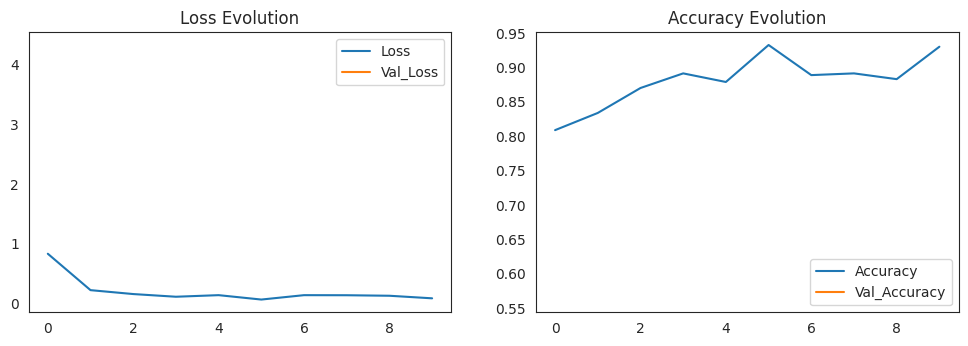

In [ ]:
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.plot(r.history['loss'], label='Loss')
plt.plot(r.history['val_loss'], label='Val_Loss')
plt.legend()
plt.title('Loss Evolution')

plt.subplot(2, 2, 2)
plt.plot(r.history['accuracy'], label='Accuracy')
plt.plot(r.history['val_accuracy'], label='Val_Accuracy')
plt.legend()
plt.title('Accuracy Evolution')

In [ ]:
evaluation = model.evaluate(test)
print(f"Test Accuracy: {evaluation[1] * 100:.2f}%")

evaluation = model.evaluate(train)
print(f"Train Accuracy: {evaluation[1] * 100:.2f}%")

624/624 [==============================] - 163s 262ms/step - loss: 0.6426 - accuracy: 0.8029
Test Accuracy: 80.29%
653/653 [==============================] - 331s 507ms/step - loss: 0.1967 - accuracy: 0.9255
Train Accuracy: 92.55%


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

pred = model.predict(test)

print(confusion_matrix(test.classes, pred > 0.5))
pd.DataFrame(classification_report(test.classes, pred > 0.5, output_dict=True))

624/624 [==============================] - 32s 50ms/step
[[123 111]
 [ 20 370]]


,0,1,accuracy,macro avg,weighted avg
precision,0.860140,0.769231,0.790064,0.814685,0.803322
recall,0.525641,0.948718,0.790064,0.737179,0.790064
f1-score,0.652520,0.849598,0.790064,0.751059,0.775694
support,234.000000,390.000000,0.790064,624.000000,624.000000


In [ ]:
print(confusion_matrix(test.classes, pred > 0.7))
pd.DataFrame(classification_report(test.classes, pred > 0.7, output_dict=True))

[[147  87]
 [ 32 358]]


,0,1,accuracy,macro avg,weighted avg
precision,0.821229,0.804494,0.809295,0.812862,0.810770
recall,0.628205,0.917949,0.809295,0.773077,0.809295
f1-score,0.711864,0.857485,0.809295,0.784675,0.802877
support,234.000000,390.000000,0.809295,624.000000,624.000000


In [ ]:
#DenseNet
from keras.applications.densenet import DenseNet121
from keras.layers import Dense, GlobalAveragePooling2D
from keras.models import Model
from keras import backend as K

base_model = DenseNet121(input_shape=(180, 180, 3), include_top=False, weights='imagenet', pooling='avg')

base_model.summary()

29084464/29084464 [==============================] - 0s 0us/step
Model: "densenet121"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 180, 180, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 186, 186, 3)  0          ['input_1[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 90, 90, 64)   9408        ['zero_padding2d[0][0]']         
                                                                                                  
 conv1/bn (BatchNormali

In [ ]:
layers = base_model.layers
print(f"The model has {len(layers)} layers")

The model has 428 layers


In [ ]:
print(f"The input shape {base_model.input}")
print(f"The output shape {base_model.output}")

The input shape KerasTensor(type_spec=TensorSpec(shape=(None, 180, 180, 3), dtype=tf.float32, name='input_1'), name='input_1', description="created by layer 'input_1'")
The output shape KerasTensor(type_spec=TensorSpec(shape=(None, 1024), dtype=tf.float32, name=None), name='avg_pool/Mean:0', description="created by layer 'avg_pool'")


In [ ]:

#model = Sequential()
base_model = DenseNet121(include_top=False, weights='imagenet')
x = base_model.output

x = GlobalAveragePooling2D()(x)

predictions = Dense(1, activation="sigmoid")(x)

model = Model(inputs=base_model.input, outputs=predictions)
#model.add(base_model)
#model.add(GlobalAveragePooling2D())
#model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [ ]:
r = model.fit(
    train,
    epochs=10,
    validation_data=validation,
    class_weight=class_weight,
    steps_per_epoch=100,
    validation_steps=25,
)

Epoch 1/10
100/100 [==============================] - ETA: 0s - loss: 0.1819 - accuracy: 0.8075

100/100 [==============================] - 286s 3s/step - loss: 0.1819 - accuracy: 0.8075 - val_loss: 6.7527 - val_accuracy: 0.5000
Epoch 2/10
100/100 [==============================] - 248s 2s/step - loss: 0.1069 - accuracy: 0.8875
Epoch 3/10
100/100 [==============================] - 251s 3s/step - loss: 0.1165 - accuracy: 0.8875
Epoch 4/10
100/100 [==============================] - 246s 2s/step - loss: 0.1133 - accuracy: 0.8763
Epoch 5/10
100/100 [==============================] - 245s 2s/step - loss: 0.1133 - accuracy: 0.8825
Epoch 6/10
100/100 [==============================] - 258s 3s/step - loss: 0.0879 - accuracy: 0.8950
Epoch 7/10
100/100 [==============================] - 249s 2s/step - loss: 0.0980 - accuracy: 0.8963
Epoch 8/10
100/100 [==============================] - 251s 3s/step - loss: 0.0879 - accuracy: 0.9112
Epoch 9/10
100/100 [==============================] - 247s 2s/step - loss: 0.0882 - accuracy: 0.9050
Epoch 10/10
100/100 [==============================] - 248s 

Text(0.5, 1.0, 'Accuracy Evolution')

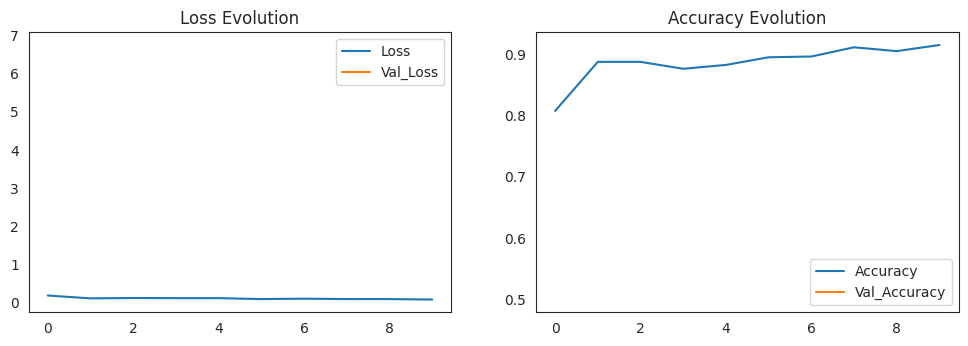

In [ ]:
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.plot(r.history['loss'], label='Loss')
plt.plot(r.history['val_loss'], label='Val_Loss')
plt.legend()
plt.title('Loss Evolution')

plt.subplot(2, 2, 2)
plt.plot(r.history['accuracy'], label='Accuracy')
plt.plot(r.history['val_accuracy'], label='Val_Accuracy')
plt.legend()
plt.title('Accuracy Evolution')

In [ ]:
evaluation = model.evaluate(test)
print(f"Test Accuracy: {evaluation[1] * 100:.2f}%")

evaluation = model.evaluate(train)
print(f"Train Accuracy: {evaluation[1] * 100:.2f}%")

624/624 [==============================] - 58s 92ms/step - loss: 2.4220 - accuracy: 0.4968
Test Accuracy: 49.68%
653/653 [==============================] - 377s 577ms/step - loss: 2.5768 - accuracy: 0.4592
Train Accuracy: 45.92%


In [ ]:
predicted_vals = model.predict(test, steps=len(test))

624/624 [==============================] - 59s 92ms/step


In [ ]:
print(confusion_matrix(test.classes, predicted_vals > 0.5))
pd.DataFrame(classification_report(test.classes, predicted_vals > 0.5, output_dict=True))

[[218  16]
 [309  81]]


,0,1,accuracy,macro avg,weighted avg
precision,0.413662,0.835052,0.479167,0.624357,0.677031
recall,0.931624,0.207692,0.479167,0.569658,0.479167
f1-score,0.572930,0.332649,0.479167,0.452790,0.422754
support,234.000000,390.000000,0.479167,624.000000,624.000000


In [ ]:
#Resnet
from keras.applications import ResNet50

resnet_base_model = ResNet50(input_shape=(180,180,3), include_top=False, weights='imagenet')



94765736/94765736 [==============================] - 0s 0us/step


In [ ]:
resnet_base_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 180, 180, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 186, 186, 3)  0           ['input_3[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 90, 90, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 90, 90, 64)   256         ['conv1_conv[0][0]']      

In [ ]:
    resnet_model = tf.keras.Sequential([
        resnet_base_model,
        GlobalAveragePooling2D(),
        Dense(512, activation="relu"),
        BatchNormalization(),
        Dropout(0.6),
        Dense(128, activation="relu"),
        BatchNormalization(),
        Dropout(0.4),
        Dense(64,activation="relu"),
        BatchNormalization(),
        Dropout(0.3),
        Dense(1,activation="sigmoid")
    ])

    opt = tf.keras.optimizers.Adam(learning_rate=0.001)
    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    resnet_model.compile(optimizer=opt,loss='binary_crossentropy',metrics=METRICS)

In [ ]:
r = resnet_model.fit(train,
          epochs=10,
          validation_data=validation,
          class_weight=class_weight,
          steps_per_epoch=100,
          validation_steps=25)


Epoch 1/10
100/100 [==============================] - ETA: 0s - loss: 0.2700 - accuracy: 0.6350 - precision: 0.8596 - recall: 0.5976

100/100 [==============================] - 315s 3s/step - loss: 0.2700 - accuracy: 0.6350 - precision: 0.8596 - recall: 0.5976 - val_loss: 1008.1211 - val_accuracy: 0.5000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/10
100/100 [==============================] - 296s 3s/step - loss: 0.1999 - accuracy: 0.7700 - precision: 0.9352 - recall: 0.7376
Epoch 3/10
100/100 [==============================] - 293s 3s/step - loss: 0.1805 - accuracy: 0.7862 - precision: 0.9388 - recall: 0.7581
Epoch 4/10
100/100 [==============================] - 289s 3s/step - loss: 0.1735 - accuracy: 0.7962 - precision: 0.9374 - recall: 0.7715
Epoch 5/10
100/100 [==============================] - 287s 3s/step - loss: 0.1507 - accuracy: 0.8200 - precision: 0.9507 - recall: 0.8020
Epoch 6/10
100/100 [==============================] - 291s 3s/step - loss: 0.1698 - accuracy: 0.8112 - precision: 0.9421 - recall: 0.8013
Epoch 7/10
100/100 [==============================] - 287s 3s/step - loss: 0.1522 - a

Text(0.5, 1.0, 'Accuracy Evolution')

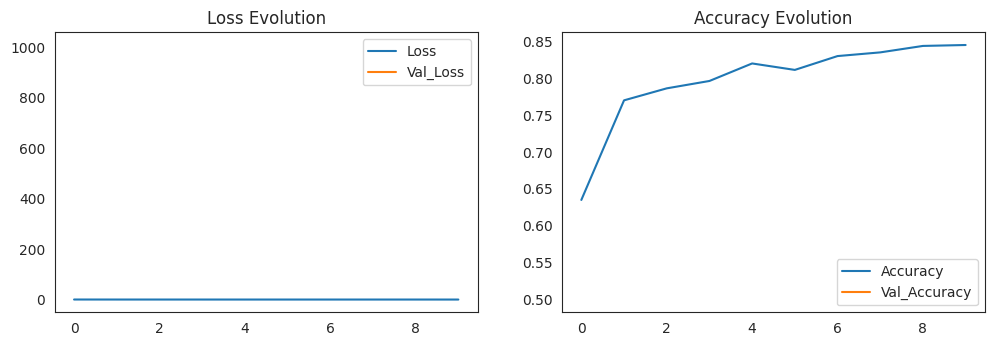

In [ ]:
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.plot(r.history['loss'], label='Loss')
plt.plot(r.history['val_loss'], label='Val_Loss')
plt.legend()
plt.title('Loss Evolution')

plt.subplot(2, 2, 2)
plt.plot(r.history['accuracy'], label='Accuracy')
plt.plot(r.history['val_accuracy'], label='Val_Accuracy')
plt.legend()
plt.title('Accuracy Evolution')

In [ ]:
evaluation =resnet_model.evaluate(test)
print(f"Test Accuracy: {evaluation[1] * 100:.2f}%")

evaluation = resnet_model.evaluate(train)
print(f"Train Accuracy: {evaluation[1] * 100:.2f}%")

624/624 [==============================] - 70s 113ms/step - loss: 0.4664 - accuracy: 0.7821 - precision: 0.7500 - recall: 0.9769
Test Accuracy: 78.21%
653/653 [==============================] - 467s 715ms/step - loss: 0.2901 - accuracy: 0.9239 - precision: 0.9475 - recall: 0.9502
Train Accuracy: 92.39%
